In [50]:
import pandas as pd

prompt_vs_context = pd.read_csv('data/MTBP/Prompt_vs_context/prompt_vs_context.csv')
length_penalty_token = pd.read_csv('data/MTBP/Prompt_vs_context/data_length_penalty_processed.csv')
length_penalty_word= pd.read_csv('data/MTBP/Prompt_vs_context/data_length_penalty_words.csv')
length_penalty_line = pd.read_csv('data/MTBP/Prompt_vs_context/data_length_penalty_lines.csv')


In [51]:
def keep_only_generated_code_prompts(codes):
    """ Takes as input a list of codes and return the generated codes as a list of generated code.
    """
    generated_code = []

    for i in range(len(codes)):
        lines = codes[i].split('\n')
        code = lines[1:]
        generated_code.append('\n'.join(code))

    return generated_code

def keep_only_generated_code_context(codes):
    """ Takes as input a list of codes and return the generated codes as a list of generated code.
    """
    generated_codes = []

    for i in range(len(codes)):
        text = process_function_with_context(codes[i], i)
        generated_codes.append(text)
        
    return generated_codes

def process_function_with_context(text, prompt_index):
    # Split the text into lines
    lines = text.split('\n')
    
    # Initialize counter for the prompt index
    prompt_counter = -1
    # Initialize variable to store the result
    result = []
    
    # Iterate over the lines
    for line in lines:
        # If the line starts with '#', increment the prompt counter
        if line.strip().startswith('#'):
            prompt_counter += 1
        
        # If the current prompt counter equals the given prompt index, add the line to the result
        if prompt_counter == prompt_index and not line.strip().startswith('#'):
            result.append(line.strip())
    
    # Join the result lines with '\n' and return it
    return '\n'.join(result)

In [52]:
import ast
import re
from collections import Counter


def process_generated_codes(data, length_penalty=False):

    generated_prompts = []
    generated_contexts = []

    for j in range(len(data)):

        generated_prompt = []
        generated_context = []

        if length_penalty:
            codes_context = ast.literal_eval(data.iloc[j]['lenght_penalty_generation'])

            for i in range(len(codes_context)):
                generated_context = keep_only_generated_code_context(codes_context)
            
        else:
            codes_prompt = ast.literal_eval(data.iloc[j]['codes_by_prompts']) 
            codes_context = ast.literal_eval(data.iloc[j]['codes_with_context'])

            for i in range(len(codes_prompt)):
                generated_prompt = keep_only_generated_code_prompts(codes_prompt)
                generated_context = keep_only_generated_code_context(codes_context)
        
        generated_prompts.append(generated_prompt)
        generated_contexts.append(generated_context)

    return generated_prompts, generated_contexts

def calculate_lengths(codes_prompt, codes_context):
    lengths_prompt = [[len(code) for code in inner_list] for inner_list in codes_prompt]
    lengths_context = [[len(code) for code in inner_list] for inner_list in codes_context]
    
    return lengths_prompt, lengths_context


def get_most_common_words(codes_list1, codes_list2, topn=10):
    # Flatten the list of lists and join all the codes into a single string
    all_codes_str = ' '.join([' '.join(sublist) for sublist in codes_list1+codes_list2])

    # Use regular expressions to find all occurrences of each word
    all_words = re.findall(r'\b\w+\b', all_codes_str)

    # Use a Counter to count the occurrences of each word
    word_counter = Counter(all_words)

    # Return the top n most common words and their counts
    return word_counter.most_common(topn)

def count_number_of_eos(list_p, list_c):

    num_eos_prompt = 0
    num_eos_context = 0

    idx_eos_prompt = []
    idx_eos_context = []

    for idx in range(len(list_p)):
        for idx_prompt in range(len(list_p[idx])):
            if list_p[idx][idx_prompt].count('<|') != 0:
                num_eos_prompt+=1
                idx_eos_prompt.append([idx, idx_prompt])
            if list_c[idx][idx_prompt].count('<|') != 0:
                num_eos_context+=1
                idx_eos_context.append([idx, idx_prompt])
    
    return (num_eos_prompt, idx_eos_prompt), (num_eos_context, idx_eos_context)

In [56]:
# context vs prompt
gen_p, gen_c = process_generated_codes(prompt_vs_context)
most_common_words = get_most_common_words(gen_p, gen_c)
lengths_prompt, lengths_context = calculate_lengths(gen_p, gen_c)
(count_eos_p, indices_eos_p), (count_eos_c, indices_eos_c) = count_number_of_eos(gen_p, gen_c)

# length penalty token
_, len_penalty_token= process_generated_codes(length_penalty_token, True)
most_common_words_pen_tokens = get_most_common_words(len_penalty_token, [])
lengths_penalty_token, lengths_context_token = calculate_lengths(len_penalty_token, gen_c)
_, (count_eos_penalty_token, indices_eos_penalty_token) = count_number_of_eos(gen_p, len_penalty_token)


# length penalty words
_, len_penalty_word= process_generated_codes(length_penalty_word, True)
most_common_words_pen_words = get_most_common_words(len_penalty_word, [])
lengths_penalty_word, lengths_context_word = calculate_lengths(len_penalty_word, gen_c)
_, (count_eos_penalty_word, indices_eos_penalty_word) = count_number_of_eos(gen_p, len_penalty_word)

# length penalty lines
_, len_penalty_line= process_generated_codes(length_penalty_line, True)
most_common_words_pen_lines = get_most_common_words(len_penalty_line, [])
lengths_penalty_line, lengths_context_line = calculate_lengths(len_penalty_line, gen_c)
_, (count_eos_penalty_line, indices_eos_penalty_line) = count_number_of_eos(gen_p, len_penalty_line)

In [59]:
most_common_words_pen_lines

[('endoftext', 2199),
 ('print', 849),
 ('i', 500),
 ('in', 428),
 ('0', 355),
 ('return', 306),
 ('1', 282),
 ('for', 281),
 ('if', 249),
 ('import', 238)]

In [60]:
import statistics

def get_descriptive_stats(list_of_lists):
    # Flatten the list of lists
    flat_list = [num for sublist in list_of_lists for num in sublist]

    stats = {}

    stats['mean'] = statistics.mean(flat_list)
    stats['median'] = statistics.median(flat_list)
    try:
        stats['mode'] = statistics.mode(flat_list)
    except statistics.StatisticsError:
        stats['mode'] = 'No unique mode found'
    stats['stdev'] = statistics.stdev(flat_list)
    stats['variance'] = statistics.variance(flat_list)
    stats['min'] = min(flat_list)
    stats['max'] = max(flat_list)
    stats['range'] = stats['max'] - stats['min']

    return stats

In [61]:
descriptive_stats_prompts = get_descriptive_stats(lengths_prompt)
descriptive_stats_context = get_descriptive_stats(lengths_context)
descriptive_stats_token = get_descriptive_stats(len_penalty_token)
descriptive_stats_word = get_descriptive_stats(len_penalty_word)
descriptive_stats_token = get_descriptive_stats(len_penalty_token)

TypeError: can't convert type 'str' to numerator/denominator

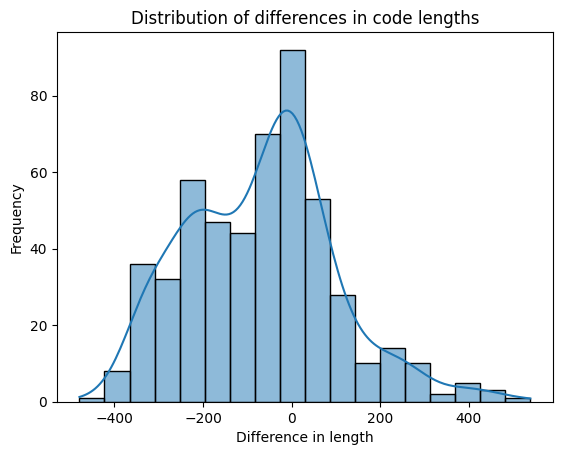

Normality test p-value: 0.0006498047071727048
The differences do not follow a normal distribution.


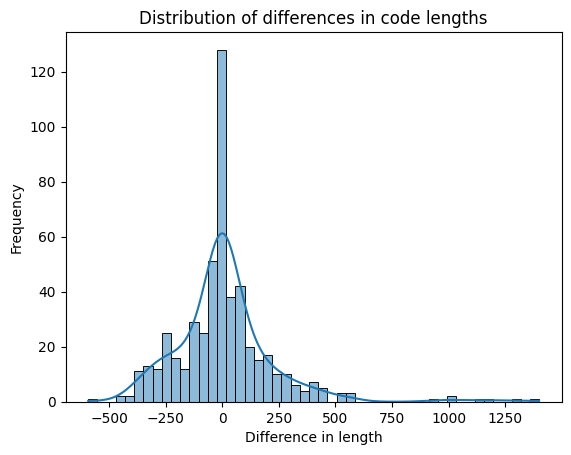

Normality test p-value: 2.139999560498175e-53
The differences do not follow a normal distribution.


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

def plot_and_test_distribution(list1, list2):
    # Flatten the lists
    flat_list1 = [num for sublist in list1 for num in sublist]
    flat_list2 = [num for sublist in list2 for num in sublist]

    # Ensure both lists have the same length for difference calculation
    min_length = min(len(flat_list1), len(flat_list2))

    # Calculate the differences
    differences = np.subtract(flat_list1[:min_length], flat_list2[:min_length])

    # Plot the distribution of differences
    sns.histplot(differences, kde=True)
    plt.title('Distribution of differences in code lengths')
    plt.xlabel('Difference in length')
    plt.ylabel('Frequency')
    plt.show()

    # Perform a normality test
    k2, p = stats.normaltest(differences)
    print("Normality test p-value:", p)
    if p < 0.05:
        print("The differences do not follow a normal distribution.")
    else:
        print("The differences follow a normal distribution.")


plot_and_test_distribution(lengths_prompt, lengths_context)
# leng 
plot_and_test_distribution(lengths_penalty, lengths_context)


In [38]:
from scipy.stats import mannwhitneyu

def perform_hypothesis_testing(list1, list2):
    # Flatten the lists and keep only integer values
    flat_list1 = [num for sublist in list1 for num in sublist if isinstance(num, int)]
    flat_list2 = [num for sublist in list2 for num in sublist if isinstance(num, int)]

    stat, p = mannwhitneyu(flat_list1, flat_list2)

    return stat, p

stat, p = perform_hypothesis_testing(lengths_penalty, lengths_context)
stat, p

(122994.0, 0.05483985720054741)

<h1>Length Penalty Algorithm</h1>

Create dataset with alpha-values corresponding:
<p>reference is the length of the context less: </p>
<p></p>
        set the alpha values for all generation step in each problem
                max value equal two, smallest value is zero.five 
                keep only instruction steps codes lenghts 


In [4]:
import ast
import pandas as pd

prompt_vs_context = pd.read_csv('data/MTBP/Prompt_vs_context/prompt_vs_context.csv')
# gen_p, gen_c = process_generated_codes(prompt_vs_context)
# lengths_prompt, lengths_context = calculate_lengths(gen_p, gen_c)

def keep_only_generated_code_prompts(codes):
    """ Takes as input a list of codes and return the generated codes as a list of generated code.
    """
    generated_code = []

    for i in range(len(codes)):
        lines = codes[i].split('\n')
        code = lines[1:]
        generated_code.append('\n'.join(code))

    return generated_code

def keep_only_generated_code_context(codes):
    """ Takes as input a list of codes and return the generated codes as a list of generated code.
    """
    generated_codes = []

    for i in range(len(codes)):
        text = process_function_with_context(codes[i], i)
        generated_codes.append(text)
        
    return generated_codes

def process_function_with_context(text, prompt_index):
    # Split the text into lines
    lines = text.split('\n')
    
    # Initialize counter for the prompt index
    prompt_counter = -1
    # Initialize variable to store the result
    result = []
    
    # Iterate over the lines
    for line in lines:
        # If the line starts with '#', increment the prompt counter
        if line.strip().startswith('#'):
            prompt_counter += 1
        
        # If the current prompt counter equals the given prompt index, add the line to the result
        if prompt_counter == prompt_index and not line.strip().startswith('#'):
            result.append(line.strip())
    
    # Join the result lines with '\n' and return it
    return '\n'.join(result)

def process_generated_codes(data):

    generated_prompts = []
    generated_contexts = []

    for j in range(len(data)):

        generated_prompt = []
        generated_context = []

        codes_prompt = ast.literal_eval(data.iloc[j]['codes_by_prompts']) 
        codes_context = ast.literal_eval(data.iloc[j]['codes_with_context'])

        for i in range(len(codes_prompt)):
            generated_prompt = keep_only_generated_code_prompts(codes_prompt)
            generated_context = keep_only_generated_code_context(codes_context)
        
        generated_prompts.append(generated_prompt)
        generated_contexts.append(generated_context)

    return generated_prompts, generated_contexts

def calculate_lengths(codes_prompt, codes_context):
    lengths_prompt = [[len(code) for code in inner_list] for inner_list in codes_prompt]
    lengths_context = [[len(code) for code in inner_list] for inner_list in codes_context]
    
    return lengths_prompt, lengths_context

def normalize(list_of_lists, a=0.5, b=1.5):
    # normalizing between a and b
    flat_list = [item for sublist in list_of_lists for item in sublist]
    min_val = min(flat_list)
    max_val = max(flat_list)
    
    normalized = []
    for sublist in list_of_lists:
        norm_sublist = [round(a + (x - min_val) * (b - a) / (max_val - min_val), 3) for x in sublist]
        normalized.append(norm_sublist)
    
    return normalized

def alphas_columns(lengths_prompt, lengths_context):
    # create normalized diff
    diff_length = []

    for i in range(len(lengths_prompt)):
        lenght_step = []
        for j in range(len(lengths_prompt[i])):
            
            nominateur = lengths_prompt[i][j]
            denominateur = lengths_context[i][j]
            
            if nominateur == 0 and denominateur!= 0:
                lenght_step.append(1)
            elif denominateur == 0 and nominateur!=0:
                lenght_step.append(1)
            elif denominateur == 0 and nominateur == 0:
                lenght_step.append(1)
            else:
                lenght_step.append(nominateur/denominateur)

        diff_length.append(lenght_step)

    normalized_alphas = normalize(diff_length, 0.5, 1.5)

    return normalized_alphas


def custom_dataset(data):
    # load 
    gen_p, gen_c = process_generated_codes(data)
    lengths_prompt, lengths_context = calculate_lengths(gen_p, gen_c)

    # create alphas
    alphas = alphas_columns(lengths_prompt, lengths_context)

    # add to dataset
    data['alphas'] = alphas

    return data

In [39]:
dataset = custom_dataset(prompt_vs_context)

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
import torch.nn as nn
import torch
import re

class MySantaCoder(nn.Module):
    def __init__(self, max_tokens = 128, num_sol = 1):
        super(MySantaCoder, self).__init__()
        self.checkpoint = "bigcode/santacoder"
        self.model = AutoModelForCausalLM.from_pretrained(self.checkpoint, trust_remote_code=True)
        self.tokenizer = AutoTokenizer.from_pretrained(self.checkpoint)
        self.max_new_tokens = max_tokens
        self.num_sol = num_sol

    def forward(self, input_ids):

        # setting the generation config with the associated lenght penalty
        generation_config = GenerationConfig(   
            do_sample = True,  
            num_return_sequences = self.num_sol,
            output_scores = True,
            top_p = 0.8,
            temperature = 0.95,                
            max_new_tokens = self.max_new_tokens,
            eos_token_id=self.model.generation_config.eos_token_id,
            bos_token_id=self.model.generation_config.bos_token_id
                )

        # forward
        outputs= self.model.generate(input_ids, generation_config)
        return outputs

    def decode_output(self, encoded_output):
        output = self.tokenizer.decode(encoded_output)
        return output

    def post_generation_processing(self, code):
        # split it into list of blocks
        list_blocks = re.split('def |class |assert |print ', code)
        
        if 'init' in list_blocks[1]:
            fill_word = '\nclass '
        else:
            fill_word = '\ndef '
        
        # keep only the first block
        result = list_blocks[0] + fill_word + list_blocks[1]
        
        # remove all trailing newlines
        while result.endswith('\n'):
            result = result[:-1]
        
        # remove all leading newlines
        while result.startswith('\n'):
            result = result[1:]
        return result

    def extract_function_block(self, text):
        lines = text.split('\n')
        result = []

        indent_level = None
        for line in lines:
            if line.strip() == '':  # Ignore empty lines
                continue

            current_indent = len(line) - len(line.lstrip())

            if indent_level is None:  # For the first 'def' line
                indent_level = current_indent
                result.append(line)
                continue

            if current_indent > indent_level:  # Inside the function's scope
                result.append(line)
            else:  # Outside the function's scope or another function
                break

        return '\n'.join(result)

def compute_log_likelihood(model, output_ids):
    with torch.no_grad():
        logits = model.model(output_ids).logits

    # Calculate probabilities
    probs = torch.nn.functional.softmax(logits, dim=-1)
    
    # Gather the probabilities for the generated tokens
    token_probs = probs.gather(-1, output_ids.unsqueeze(-1)).squeeze(-1)
    
    # Compute log likelihood for each sequence
    log_likelihoods = torch.sum(torch.log(token_probs), dim=-1)

    return log_likelihoods.squeeze().tolist()

def compute_length(tensor, stop_token=49152):
    # Find the index of the first occurrence of the stop_token
    indices = (tensor == stop_token).nonzero(as_tuple=True)[0]
    
    # If the stop_token doesn't exist in the tensor, return the length of the tensor
    if len(indices) == 0:
        return len(tensor)
    
    # Otherwise, return the index of the first occurrence
    return indices[0].item()
    
def apply_length_penalty(log_likelihood, length, alpha=0.7):
    return log_likelihood / (length**alpha)

def pick_best_length(model, output_ids, alpha):
    # Calculate the log_likelihood for each output_ids
    log_likelihoods = compute_log_likelihood(model, output_ids)

    # apply the length penalty to every sequences generated
    penalized_scores = [apply_length_penalty(ll, compute_length(output), alpha) for ll, output in zip(log_likelihoods, output_ids)]

    # pick the best one
    best_index = penalized_scores.index(max(penalized_scores))
    best_output = output_ids[best_index]

    return best_output

c:\Users\mariu\anaconda3\envs\comp0197-pt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
def list_to_tensor(lst):
    # Find the length of the longest sublist
    max_len = max(len(sublist) for sublist in lst)
    
    # Initialize a tensor of size (len(lst), max_len) filled with the stop token
    tensor = torch.full((len(lst), max_len), 49152)
    
    # Fill the tensor with values from the input list
    for i, sublist in enumerate(lst):
        for j, value in enumerate(sublist):
            tensor[i][j] = value
    
    return tensor

def generation_post_processing(model, output_ids):

    output_text = []

    for i in range(len(output_ids)):

        # decode every output
        output_function = model.decode_output(output_ids[i])

        # cut off generation
        processed_output = model.extract_function_block(output_function)

        # encode again
        encoded_output = model.tokenizer.encode(processed_output)

        # add to list
        output_text.append(encoded_output)
    
    # add the end_of_text token to get the same length in all tensors
    output_ids_processed = list_to_tensor(output_text)

    return output_ids_processed

In [37]:
import ast

def generation_functions_with_len_penalty(data, model, early_stopping = None):
    """ 
        Generation of the context functions with a evoluting length penalty.
    """

    # Codes for every problem
    codes_with_context = []

    for j in range(len(data)):
        if early_stopping is not None and j > early_stopping:
            break
        
        # Code for every prompt
        code_with_context = []

        # start with the signature for the incoming problem
        code = data.iloc[j]['signature']
        # initiate the list of prompt to generate
        prompts = ast.literal_eval(data.iloc[j]['prompts'])
        # inititate the alphas for the generation penalty
        alphas = data.iloc[j]['alphas']
        
        for i, prompt in enumerate(prompts):
            
            # input text
            function = code + '\n\t#' + prompt 
            # tokenization
            ids_function = model.tokenizer.encode(function, return_tensors='pt')

            # generation 
            output_function = model.forward(ids_function)

            # processing 
            processed_output_ids = generation_post_processing(model, output_function)
            
            # length penalty algorithm
            # select within the list of sequence generated the best one according of their log-likelihood
            best_output = pick_best_length(model, processed_output_ids, alphas[i])

            # decoding
            text_function = model.decode_output(best_output)

            # post processing
            text_function = model.post_generation_processing(text_function)

            # enlarge the context
            code = text_function

            # add to the list
            code_with_context.append(text_function)

        codes_with_context.append(code_with_context)

    return codes_with_context

In [6]:
santaCoder = MySantaCoder(max_tokens=128, num_sol=5)

In [7]:
function = 'def function(a):\n\t#Create a list of integers between 0 and a'
ids_function = santaCoder.tokenizer.encode(function, return_tensors='pt')
# generation 
output_function = santaCoder.forward(ids_function)
output_text = generation_post_processing(santaCoder, output_function)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:49152 for open-end generation.


In [ ]:
codes_with_context = generation_functions_with_len_penalty(dataset, santaCoder, 2)

Exploration of the dataset

In [48]:
def remove_endoftext(text):
    # remove all unecessary '\n' 
    new_text = text.strip()
    # remove all endoftext tokens
    return new_text.replace('<|endoftext|>', '')

def format_testing_prompt_vs_context(data):

    code_to_test = []

    for k in range(len(data)):
        # will take the last one 
        text = ast.literal_eval(data.iloc[k]['codes_with_context'])[-1]
        processed_text = remove_endoftext(text)
        code_to_test.append(processed_text)
    
    data['code_test'] = code_to_test

    return data

def format_testing_lenght_penalty(data):

    code_to_test = []

    for k in range(len(data)):
        # will take the last one 
        text = ast.literal_eval(data.iloc[k]['lenght_penalty_generation'])[-1]
        processed_text = remove_endoftext(text)
        code_to_test.append(processed_text)
    
    data['code_test'] = code_to_test

    return data

# lenght_penalty_generation

In [49]:
import pandas as pd

data_len_words = pd.read_csv('data/MTBP/Prompt_vs_context/data_length_penalty_words.csv')
data_len_token = pd.read_csv('data/MTBP/Prompt_vs_context/data_length_penalty_processed.csv')
data_len_lines = pd.read_csv('data/MTBP/Prompt_vs_context/data_length_penalty_lines.csv')
data_ProCo = pd.read_csv('data/MTBP/Prompt_vs_context/prompt_vs_context.csv')

data_len_w = format_testing_lenght_penalty(data_len_words)
data_len_t = format_testing_lenght_penalty(data_len_token)
data_len_l = format_testing_lenght_penalty(data_len_lines)
data_prC = format_testing_prompt_vs_context(data_ProCo)

data_len_w.to_csv('data/MTBP/Prompt_vs_context/words_length_penalty.csv')
data_len_t.to_csv('data/MTBP/Prompt_vs_context/token_length_penalty.csv')
data_len_l.to_csv('data/MTBP/Prompt_vs_context/lines_lenght_penalty.csv')
data_prC.to_csv('data/MTBP/Prompt_vs_context/prompt_vs_context.csv')